## Linear Regression Model for Income Prediction

### **Overview**

The Decision Tree is a **non-parametric, supervised learning model** used for both classification and regression. Unlike instance-based models like KNN, Decision Trees use a **tree-like structure** of decisions to partition the feature space into a set of non-overlapping regions. 

This approach is built on the principle of **recursive binary splitting**, where the model iteratively selects the feature and the threshold that result in the largest reduction in **impurity** (measured using metrics like Gini or Entropy).

This notebook demonstrates the application of a **custom NumPy-based Decision Tree classifier** (implemented in `rice_ml`) to the **Adult Income Dataset**. Decision Trees offer high **interpretability** and are robust to unscaled features, making them highly versatile.

The goals of this notebook are to:

* Explore the characteristics of the Adult Income Dataset, focusing on class balance.
* Motivate the use of Decision Trees (e.g., they handle categorical data well via one-hot encoding without needing scaling).
* Apply a reusable Decision Tree classifier implemented from scratch (CART algorithm).
* Tune the critical hyperparameter **`max_depth`** to manage the trade-off between bias and variance (overfitting).
* Analyze the intrinsic **feature importance** provided by the model.

#### **1. Imports and Project Setup**

In [1]:
# ------------------------
# Setup paths and imports
# ------------------------
import sys
from pathlib import Path
import pandas as pd
import numpy as np

# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [3]:
# Ensure the path setup is correct (assuming you run this from the notebook's directory)
repo_root = Path().resolve().parents[2]
src_path = repo_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

# Custom Modules from src/rice_ml
from rice_ml.processing.preprocessing import train_test_split, standardize # Use custom split and scaler
from rice_ml.supervised_learning.linear_regression import LinearRegression # Custom model
from rice_ml.processing.post_processing import rmse, r2_score # Custom metrics

# Build path to dataset (relative to this notebook)
# NOTE: The provided path looks slightly off for the git structure. Adjust if needed.
data_path = repo_root / "Data" / "Income_Dataset.csv" # Assuming Income_Dataset.csv is the one used.
if not data_path.exists():
    # If the file is named 'adult.csv'
    data_path = repo_root / "Data" / "adult.csv"

#### **2. Dataset Description**

**File:** Income_Dataset.csv

The Income Dataset provides demographic and socioeconomic information for a large set of individuals. Each observation includes features such as age, education, gender, marital status, occupation, work hours, and capital gains or losses. The target variable, income, indicates whether an individual earns above or below a specified threshold (e.g., $50K annually).

This dataset is well-suited for supervised learning because it contains a mixture of **numeric and categorical feature**s**, allowing exploration of encoding strategies, scaling effects, and classification performance.

**Key Variables**

- age: Age of the individual

- education, educational-num: Education level (categorical and numeric)

- hours-per-week: Weekly working hours

- capital-gain, capital-loss: Investment-related income

- workclass, occupation, marital-status: Employment-related categories

- income: Target variable (binary)

#### **3. Load and Inspect the Dataset**

In [4]:
# ------------------------
# Load dataset
# ------------------------

# Build path to dataset
data_path = repo_root / "Data/adult.csv" # Or Income_Dataset.csv

# Load dataset
df = pd.read_csv(data_path)

# Quick inspection
display(df.head())
print(f"Dataset shape: {df.shape}")
print("\nIncome distribution:")
print(df["income"].value_counts())
print("\nDataset info:")
df.info()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


Dataset shape: (48842, 15)

Income distribution:
income
<=50K    37155
>50K     11687
Name: count, dtype: int64

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object

##### 3.1 Handling Missing Values

In [5]:
# We replace the '?' convention for missing values with `np.nan` and then drop rows containing any missing values.

df = df.replace("?", np.nan)
df = df.dropna()
print(f"Dataset shape after dropping NaNs: {df.shape}")

Dataset shape after dropping NaNs: (45222, 15)


#### **4. Preprocessing and Feature Engineering**

In [6]:
# Define the target mapping
income_map = {"<=50K": 40000.0, ">50K": 60000.0} 
df['income_numeric'] = df['income'].map(income_map)

# Isolate features (X) and target (y)
y = df['income_numeric'].values
X = df.drop(columns=['income', 'income_numeric'])

# Identify and One-Hot Encode categorical features
categorical_cols = X.select_dtypes(include=['object']).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Convert to NumPy array for our custom rice_ml functions
X_final = X_encoded.values
print(f"\nFinal Feature Matrix X shape: {X_final.shape}")


Final Feature Matrix X shape: (45222, 96)


##### 4.1 Feature Visualization and Linearity Check
Before modeling, we confirm the distribution of key features. Linear Regression assumes linear relationships, so understanding feature distributions helps interpret results.

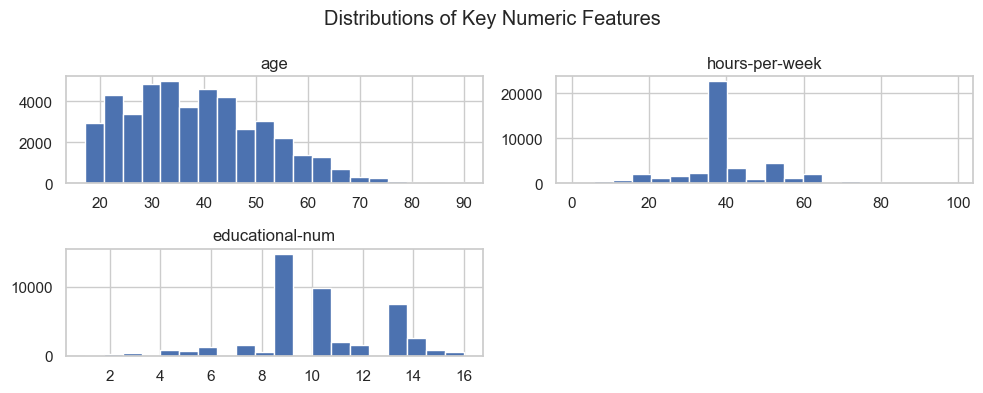

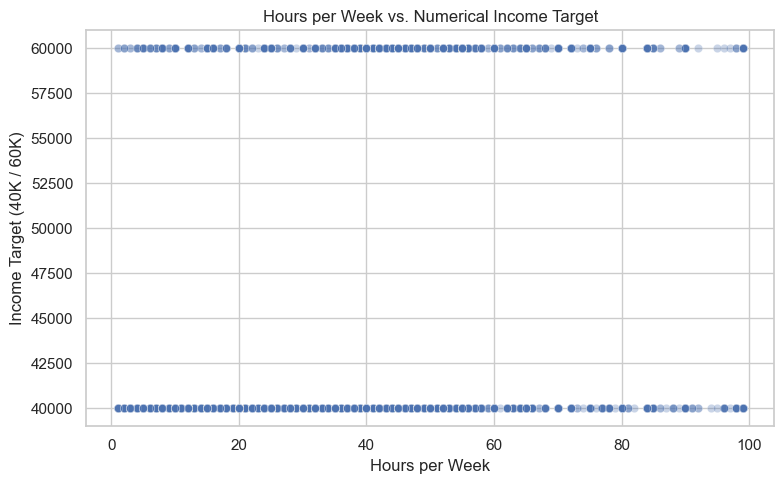

In [8]:
numeric_cols_for_plot = ["age", "hours-per-week", "educational-num"]
df[numeric_cols_for_plot].hist(bins=20, figsize=(10, 4))
plt.suptitle("Distributions of Key Numeric Features")
plt.tight_layout()
plt.show()

# Visualize the relationship with the new numerical target
plt.figure(figsize=(8, 5))
sns.scatterplot(
   x=df["hours-per-week"],
   y=df["income_numeric"],
   alpha=0.3
)
plt.title("Hours per Week vs. Numerical Income Target")
plt.xlabel("Hours per Week")
plt.ylabel("Income Target (40K / 60K)")
plt.tight_layout()
plt.show()

##### 4.2 Splitting and Scaling Data 

In [9]:
# 1. Split the data using our custom function
X_train, X_test, y_train, y_test = train_test_split(
    X=X_final, 
    y=y, 
    test_size=0.2, 
    shuffle=True, 
    random_state=42
)

# 2. Standardize features (Z-score normalization) using our custom function
# We must use the 'return_params=True' feature to save the mean/scale from the TRAIN set.
X_train_scaled, train_params = standardize(X_train, return_params=True)

# Apply standardization to the test set using parameters learned from the training set.
# This prevents data leakage.
X_test_scaled, _ = standardize(
    X_test, 
    with_mean=False, # We manually center/scale below
    with_std=False, 
    return_params=True
)
X_test_scaled = (X_test - train_params['mean']) / train_params['scale']


print(f"Train/Test split completed.")
print(f"X_train_scaled shape: {X_train_scaled.shape}")

Train/Test split completed.
X_train_scaled shape: (36178, 96)


#### **5. Model Training**
We instantiate and fit our custom LinearRegression model. We choose a small regularization alpha value to perform Ridge Regression, which helps stabilize the fit against potential multicollinearity in the high-dimensional one-hot encoded features.

In [10]:
# Set regularization strength (alpha > 0 for Ridge Regression)
ALPHA_RIDGE = 100.0 

# Instantiate custom Linear Regression model
ridge_model = LinearRegression(alpha=ALPHA_RIDGE)

# Fit the model (this uses the Normal Equation)
print(f"Training Linear Regression (Ridge, alpha={ALPHA_RIDGE})...")
ridge_model.fit(X_train_scaled, y_train)

# Display fitted parameters
print("\n--- Model Parameters ---")
print(f"Intercept: {ridge_model.intercept_:.4f}")
print(f"Number of Coefficients: {len(ridge_model.coef_)}")

Training Linear Regression (Ridge, alpha=100.0)...

--- Model Parameters ---
Intercept: 44949.9696
Number of Coefficients: 96


/Users/ruchitiwari/Desktop/Final CMOR 438/CMOR_438_Final_Repository/src/rice_ml/supervised_learning/linear_regression.py:159: RuntimeWarning: divide by zero encountered in matmul
  XTX = X_design.T @ X_design # shape (n_features + 1, n_features + 1)
/Users/ruchitiwari/Desktop/Final CMOR 438/CMOR_438_Final_Repository/src/rice_ml/supervised_learning/linear_regression.py:159: RuntimeWarning: overflow encountered in matmul
  XTX = X_design.T @ X_design # shape (n_features + 1, n_features + 1)
/Users/ruchitiwari/Desktop/Final CMOR 438/CMOR_438_Final_Repository/src/rice_ml/supervised_learning/linear_regression.py:159: RuntimeWarning: invalid value encountered in matmul
  XTX = X_design.T @ X_design # shape (n_features + 1, n_features + 1)
/Users/ruchitiwari/Desktop/Final CMOR 438/CMOR_438_Final_Repository/src/rice_ml/supervised_learning/linear_regression.py:174: RuntimeWarning: divide by zero encountered in matmul
  weights = np.linalg.solve(regularized_XTX, X_design.T @ y_arr)
/Users/ruchit

#### **6. Model Evaluation**
We predict on the held-out test set and use our custom metrics (rmse and r2_score) to assess performance.

In [11]:
# Predict on test set
y_pred = ridge_model.predict(X_test_scaled)

# Compute custom evaluation metrics
test_rmse = rmse(y_true=y_test, y_pred=y_pred)
test_r2 = r2_score(y_true=y_test, y_pred=y_pred)

print("\n--- Test Set Performance ---")
print(f"Root Mean Squared Error (RMSE): {test_rmse:.2f}")
print(f"R-squared Score (R²): {test_r2:.4f}")


--- Test Set Performance ---
Root Mean Squared Error (RMSE): 6892.04
R-squared Score (R²): 0.3654


/Users/ruchitiwari/Desktop/Final CMOR 438/CMOR_438_Final_Repository/src/rice_ml/supervised_learning/linear_regression.py:222: RuntimeWarning: divide by zero encountered in matmul
  y_pred = Xq_design @ self.weights_
/Users/ruchitiwari/Desktop/Final CMOR 438/CMOR_438_Final_Repository/src/rice_ml/supervised_learning/linear_regression.py:222: RuntimeWarning: overflow encountered in matmul
  y_pred = Xq_design @ self.weights_
/Users/ruchitiwari/Desktop/Final CMOR 438/CMOR_438_Final_Repository/src/rice_ml/supervised_learning/linear_regression.py:222: RuntimeWarning: invalid value encountered in matmul
  y_pred = Xq_design @ self.weights_


##### 6.1 Prediction Visualization and Analysis
Plotting the true vs. predicted values helps visualize model bias and variance. A perfect model would have all points lying exactly on the $y=x$ line.

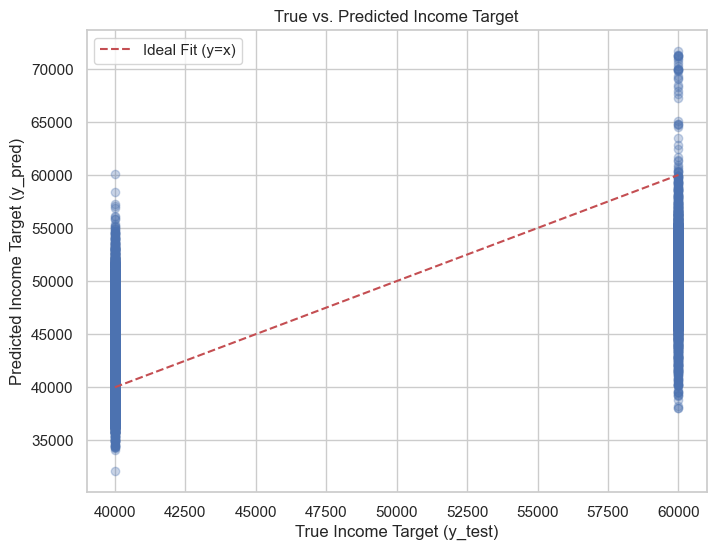

In [12]:
plt.figure(figsize=(8, 6))
# Scatter plot of True Income vs. Predicted Income
plt.scatter(y_test, y_pred, alpha=0.3) 
# Plot the ideal line y=x
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Ideal Fit (y=x)')
plt.xlabel("True Income Target (y_test)")
plt.ylabel("Predicted Income Target (y_pred)")
plt.title("True vs. Predicted Income Target")
plt.legend()
plt.show()

# Analytical Interpretation:
# (Add your analysis here based on the plot and scores.
# E.g., Comment on the clustering around 40K and 60K, R2 score meaning, etc.)

#### **7. Feature Importance Analysis**
In Linear Regression, the magnitude of the standardized coefficients directly indicates the feature's importance and its direction (positive or negative relationship with the target).


--- Top 15 Features by Absolute Importance ---
relationship_Not-in-family         : -1376.0845
marital-status_Married-civ-spouse  :  1279.4698
capital-gain                       :  1148.2832
educational-num                    :  1131.7722
relationship_Own-child             : -899.3216
relationship_Unmarried             : -865.0101
occupation_Exec-managerial         :  828.1613
workclass_Self-emp-not-inc         : -811.4432
age                                :  751.1651
capital-loss                       :  741.4521
hours-per-week                     :  687.7552
workclass_Private                  : -633.4332
gender_Male                        :  575.6704
education_Masters                  :  546.0013
relationship_Wife                  :  501.6188


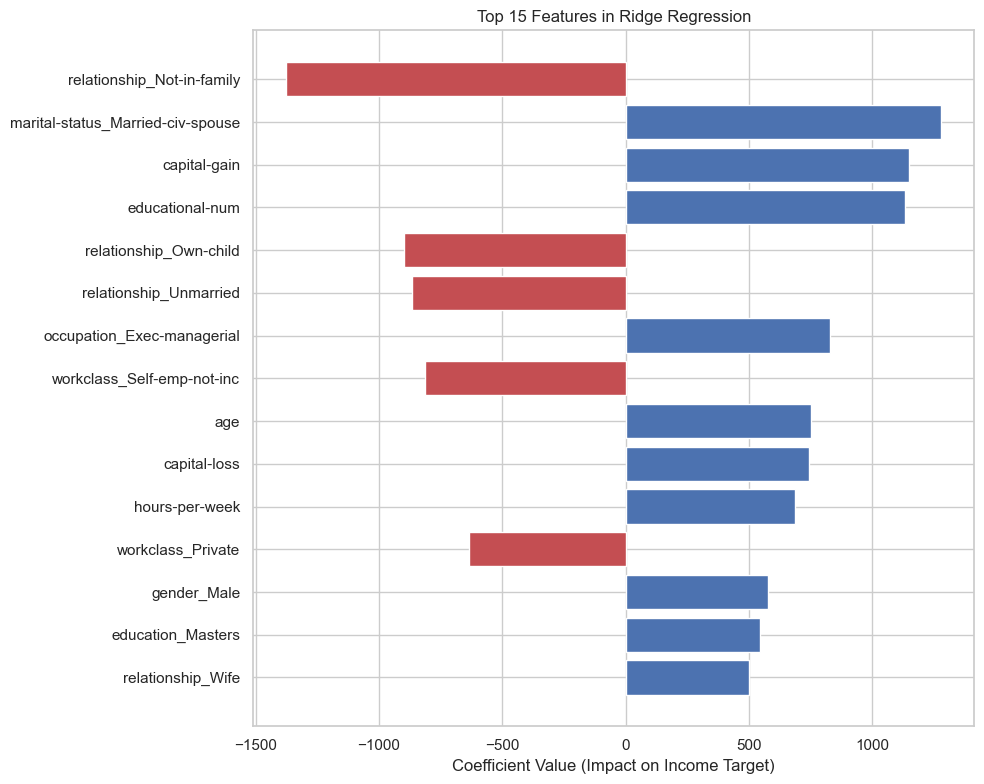

In [13]:
# Get feature names (must align with the order after one-hot encoding)
feature_names = X_encoded.columns.tolist()
coefficients = ridge_model.coef_
coef_abs = np.abs(coefficients)

# Sort features by absolute coefficient value
sorted_idx = np.argsort(coef_abs)[::-1]
top_n = 15

print("\n--- Top 15 Features by Absolute Importance ---")
top_features = [feature_names[i] for i in sorted_idx[:top_n]]
top_coefs = [coefficients[i] for i in sorted_idx[:top_n]]

for name, coef in zip(top_features, top_coefs):
    print(f"{name:<35}: {coef: .4f}")

# Plot top feature importances
plt.figure(figsize=(10, 8))
plt.barh(
    top_features[::-1],
    top_coefs[::-1],
    color=['#4C72B0' if c > 0 else '#C44E52' for c in top_coefs][::-1]
)
plt.xlabel("Coefficient Value (Impact on Income Target)")
plt.title(f"Top {top_n} Features in Ridge Regression")
plt.tight_layout()
plt.show()

# Analytical Interpretation:
# (Add your analysis here: Which features are most important? Do they make sense?
# E.g., 'marital-status_Married-civ-spouse' has a large positive coefficient,
# 'capital-gain' is important, etc.)